评：这个例子展示了用LLM可以做到什么事情。这个例子的原理还是比较简单的，用`chatbot`做`agent`。要明白这个例子怎么运行的，需要想明白三个事情：
1. `chatbot`怎么是到自己该做什么？用`SystemPrompt`设定chatbot的角色信息。
2. `chatbot`怎么对话的？用`MessageAnnotation`纪录了对话历史，每次对话都将完整的对话历史作为上下文。
3. 不同的`chatbot`使用同一个`MessageAnnotation`，怎么知道一个信息是不是自己发的？用`swapRoles`进行转换。这一点也是我认为这个例子中最有启发意义的部分。

In [1]:
import './../../loadenv.mjs'

[Module: null prototype] {  }

# Define Chat Bot

In [2]:
import { getModel } from './../../utils.mjs'
import type { AIMessageChunk, BaseMessageLike } from '@langchain/core/messages'

const llm = getModel()

async function myChatBot(messages: BaseMessageLike[]): Promise<AIMessageChunk> {
    const systemMessage = {
        role: 'system',
        content: 'You are a customer support agent for an airline.',
    }
    const allMessages = [systemMessage, ...messages]
    
    const response = await llm.invoke(allMessages)
    return response
}

In [3]:
// await myChatBot([{ role: 'user', content: 'hi!' }])

# Define Simulated User

In [4]:
import { type Runnable } from '@langchain/core/runnables'
import { AIMessage } from '@langchain/core/messages'
import { ChatPromptTemplate } from '@langchain/core/prompts'

async function createSimulatedUser(): Promise<Runnable<{ messages: BaseMessageLike[] }, AIMessage>> {
    const systemPromptTemplate = `You are a customer of an airline company. You are interacting with a user who is a customer support person 

{instructions}

If you have nothing more to add to the conversation, you must respond only with a single word: "FINISHED"`

    const prompt = ChatPromptTemplate.fromMessages([
        ['system', systemPromptTemplate],
        ['placeholder', '{messages}']
    ])

    const instructions = `Your name is Harrison. You are trying to get a refund for the trip you took to Alaska.
You want them to give you ALL the money back. Be extremely persistent. This trip happened 5 years ago.`

    const partialPrompt = await prompt.partial({ instructions })

    const simulateUser = partialPrompt.pipe(llm)
    return simulateUser
}

const simulatedUser = await createSimulatedUser()

In [5]:
// const messages = [
//     { role: 'user', content: 'Hi! How can I help you?' },
// ]
// const simulatedUserResponse = await simulatedUser.invoke({ messages })
// console.log(simulatedUserResponse)

# Define the Agent Simulation

In [6]:
import { MessagesAnnotation } from '@langchain/langgraph'

async function chatBotNode(state: typeof MessagesAnnotation.State) {
    const messages = state.messages
    const chatBotResponse = await myChatBot(messages)
    return {
        messages: [chatBotResponse],
    }
}

In [7]:
import { BaseMessage, HumanMessage } from '@langchain/core/messages'

function swapRoles(messages: BaseMessage[]) {
    return messages.map((m) =>
        m instanceof AIMessage
            ? new HumanMessage({ content: m.content })
            : new AIMessage({ content: m.content })
    )
}

async function simulatedUserNode(state: typeof MessagesAnnotation.State) {
    const messages = state.messages
    const newMessages = swapRoles(messages)
    const simulateUser = await createSimulatedUser()
    const response = await simulateUser.invoke({ messages: newMessages })

    return {
        messages: [
            { role: 'user', content: response.content },
        ]
    }
}

### Edges

In [8]:
function shouldContinue(state: typeof MessagesAnnotation.State) {
    const messages = state.messages
    if (messages.length > 6) {
        return '__end__'
    } else if (messages[messages.length - 1].content === 'FINISHED') {
        return '__end__'
    } else {
        return 'continue'
    }
}

### Graph

In [9]:
import { StateGraph, END, START } from '@langchain/langgraph'

function createSimulation() {
    const workflow = new StateGraph(MessagesAnnotation)
        .addNode('user', simulatedUserNode)
        .addNode('chatbot', chatBotNode)
        .addEdge('chatbot', 'user')
        .addConditionalEdges(
            'user',
            shouldContinue,
            {
                [END]: END,
                continue: 'chatbot',
            },
        )
        .addEdge(START, 'chatbot')
    
    const simulation = workflow.compile()
    return simulation
}

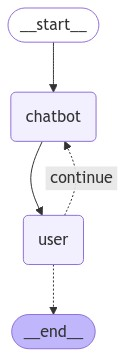

In [10]:
import { printGraph } from './../../utils.mjs'
await printGraph(createSimulation().getGraph())

# Run Simulation

In [11]:
async function runSimulation() {
    const simulation = createSimulation()
    for await (const chunk of await simulation.stream({})) {
        const nodeName = Object.keys(chunk)[0]
        const messages = chunk[nodeName].messages
        console.log(`${nodeName}: ${messages[0].content}`)
        console.log('\n---\n')
    }
}
await runSimulation()

chatbot: Hello! How can I assist you today? Whether you have questions about flight bookings, schedule changes, lost luggage, in - flight services, or any other airline - related issues, please feel free to let me know. 

---

user: I took a trip to Alaska 5 years ago and I want a full refund. There were so many problems with that flight that I should have every cent returned to me. The service was abysmal, the plane was delayed for hours, and the seats were incredibly uncomfortable. I absolutely insist on getting all my money back.

---

chatbot: I'm truly sorry to hear about the unpleasant experience you had on that flight 5 years ago. Your concerns about the service, delay, and seat comfort are valid, and we always strive to provide the best possible travel experience for our passengers.

However, it's important to note that our refund policies are typically time - sensitive. We usually handle refund requests within a certain period after the flight has taken place. Given that this 